### Linear regression

In [1]:
import pandas as pd
import utils
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# config

ALLDATA = True # if False -> smaller dataset

BATCH_SIZE = 512  
LEARNING_RATE = 1e-4  # 1e-5 was too small for 'LVtot_kalibriert' and 'LVtot' 
NUM_WORKERS = 10
NUM_EPOCHS = 500
LR_DECAY_AFTER_EPOCH = 300  
GENERATION_AFTER_EPOCH = NUM_EPOCHS # number of epochs after which the model generates a sample
SIG_A = "AoP"           # Drucksignal Hauptschlagader = Aortendruck
SIG_B = "VADcurrent"    # VAD Strom [A] – Pumpemstrom in Ampere
SIG_C = "VadQ"          # Fluss durch VAD (VAD = Ventrikular assistance device = Pumpe) = Pumpenfluss
SIG_D = "LVP"           # Ventrikeldruck links = Drucksignal der linken Herzkammer
TARGET = "LVtot_kalibriert"
feature_names = [SIG_A, SIG_C, SIG_D]
CHANNELS = len(feature_names)
WINDOW = 256
target = TARGET

In [11]:
if ALLDATA == False:
    # load only a small part of the data and drop the unnecessary columns
    # paths of only a small part of the data
    path = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/LeRntVAD_csv_exports_not_all_the_data/constant_speed_interventions/" 
    df = utils.load_csv(path)
    df = utils.drop_cols(df)
    df = df.dropna()

    # select only rows where 'Phasenzuordnung' is 1
    # df = df.loc[df['Phasenzuordnung'] == 1]

    print(df.shape) 

(8072873, 13)


In [12]:
if ALLDATA == True:
    # Load all the data and drop unnecessary columns
    # We load the data separately, to avoid a Runtime error

    # all the data
    path_1 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_1"  
    path_2 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_2"
    path_3 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_3"
    # path_4 = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files/Data_split_4"

    df_1 = utils.load_csv(path_1)
    df_1 = utils.drop_cols(df_1)
    df_1 = utils.remove_strings(df_1)
    df_1 = utils.subsample(df_1, 10)

    df_2 = utils.load_csv(path_2)
    df_2 = utils.drop_cols(df_2)
    df_2 = utils.remove_strings(df_2)
    df_2 = utils.subsample(df_2, 10)

    df_3 = utils.load_csv(path_3)
    df_3 = utils.drop_cols(df_3)
    df_3 = utils.remove_strings(df_3)
    df_3 = utils.subsample(df_3, 10)

    df_4 = utils.load_csv(path_4)
    df_4 = utils.drop_cols(df_4)
    df_4 = utils.remove_strings(df_4)
    df_4 = utils.subsample(df_4, 10)

    # concatenate the separate dataframes
    df = pd.concat([df_1, df_2, df_3, df_4], axis=0, ignore_index=True)
    df = df.dropna()

    print('Size of the whole dataset',df.shape)
    # select only rows where 'Phasenzuordnung' is 1
    # df = df.loc[df['Phasenzuordnung'] == 1]
    # print('Size of dataset with only the first phase',df.shape)

In [13]:
# print(df.shape)
# df = utils.remove_strings(df)
# print(df.shape)
# df = utils.subsample(df, 10)
# print(df.shape)

(8072873, 13)
(8072873, 13)
(807287, 13)


(807287, 13)


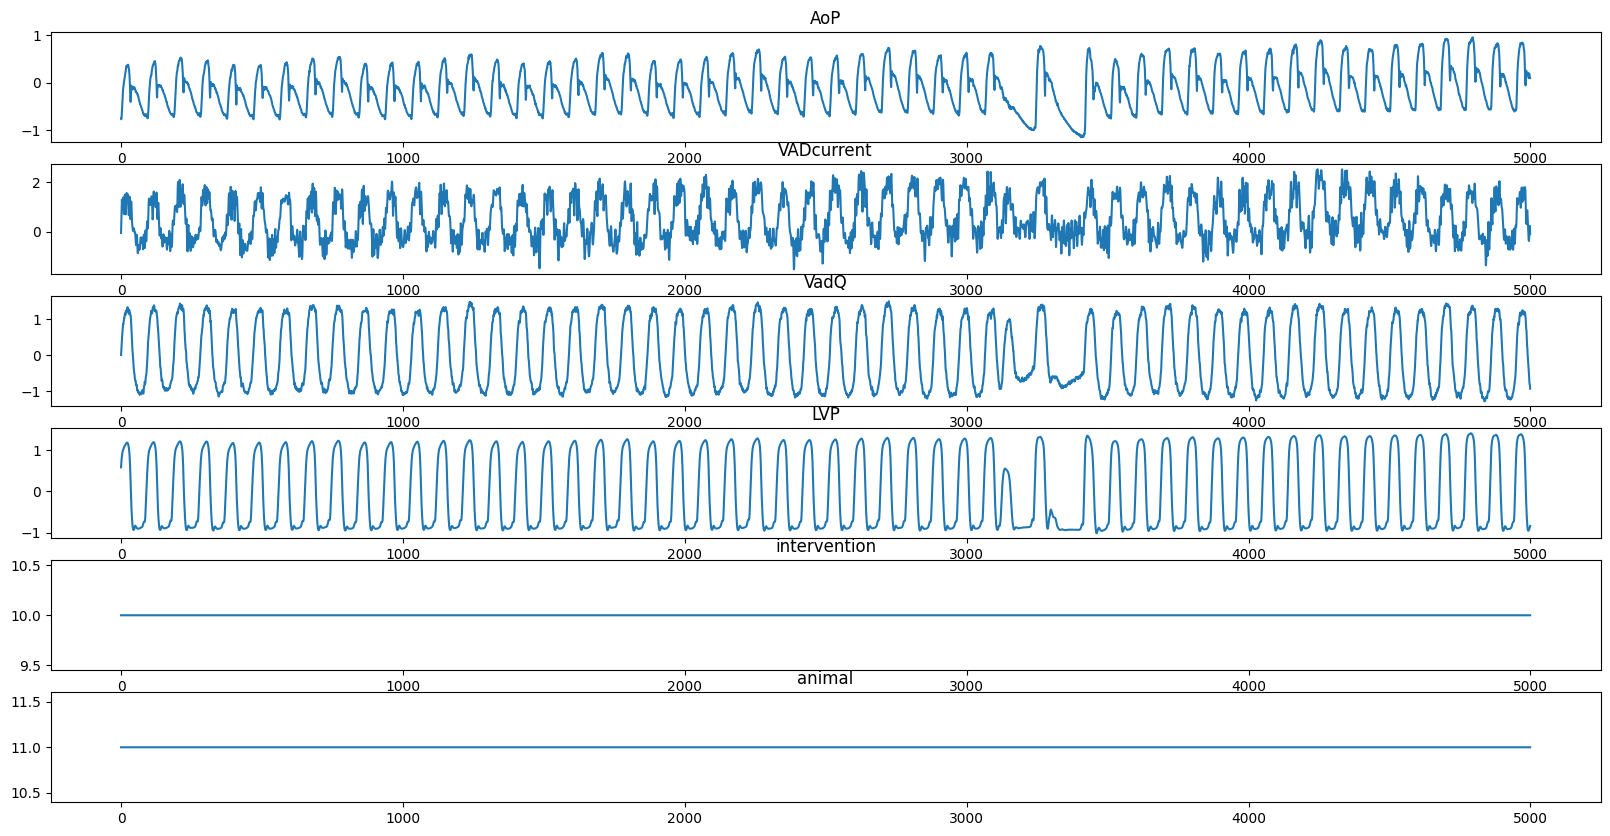

In [14]:
df_IPA = df[['intervention', 'Phasenzuordnung', 'animal']]

# split df into separate dataframes for each animal
scaler = StandardScaler()
df_temp = pd.DataFrame()

#utils.visualize(df, [SIG_A, SIG_B, SIG_C, SIG_D, 'intervention', 'animal'], 72094)

for animal in df['animal'].unique():
    # split df into separate dataframes for each animal
    df_animal = df.loc[df['animal'] == animal]
    df_animal = utils.normalize(df_animal, scaler)
    # append df_animal to df_temp
    df_temp = pd.concat([df_temp, df_animal], axis=0, ignore_index=True)

print(df_temp.shape)
df = df_temp
df = df.drop(columns=['intervention', 'Phasenzuordnung', 'animal'])
df = df.join(df_IPA)
utils.visualize(df, [SIG_A, SIG_B, SIG_C, SIG_D, 'intervention', 'animal'], 5000)

In [15]:
# remove animals with less than 10 data points
df = df.groupby('animal').filter(lambda x: len(x) > 10)
print('\nDifferent animal IDs after removing those with less than 10 data points: \n',len(df['animal'].unique()))

all_animals = df['animal'].unique()
# pick 2 random animals for test data
test_animals = df['animal'].sample(n=1, random_state=1).unique()

# remove test animals from train animals
train_animals =  [x for x in all_animals if x not in test_animals]

print('\nTest animals:', test_animals)
# test data
df_test = df[df['animal'].isin(test_animals)]

# train dataframe with only animals from train_animals
df_train = df[df['animal'].isin(train_animals)]
print('\nDifferent animal IDs after removing those that are in the test dataset: \n',len(df_train['animal'].unique()))


print('\nTrain data shape:', df_train.shape)
print('\nTest data shape:', df_test.shape)

#print('Unique animals in df_train: ',df_train['animal'].unique())
#print('Unique animals in df_test: ',df_test['animal'].unique())

# lengt of df_train
print('\nThe test dataset is {} percent of the whole data: '.format((len(df_test)/(len(df_train) + len(df_test))) * 100))


Different animal IDs after removing those with less than 10 data points: 
 6

Test animals: [16]

Different animal IDs after removing those that are in the test dataset: 
 5

Train data shape: (636231, 13)

Test data shape: (171038, 13)

The test dataset is 21.187237463596396 percent of the whole data: 


In [16]:
df_LR = df_train[[SIG_A, SIG_B, SIG_C, SIG_D, 'intervention', 'Phasenzuordnung']]
target = df_train[[TARGET]]

# convert to numpy array
X_train = df_LR.to_numpy()
y_train = target.to_numpy()

reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X_train, y_train))
print(reg.coef_)
print(reg.intercept_)

0.4690415699693894
[[-0.0989055   0.3263973  -1.18742742  0.49428261  0.00496007  0.01639459]]
[-0.11114439]


MSE:  0.43572651873231255
L1:  0.5206536740795193


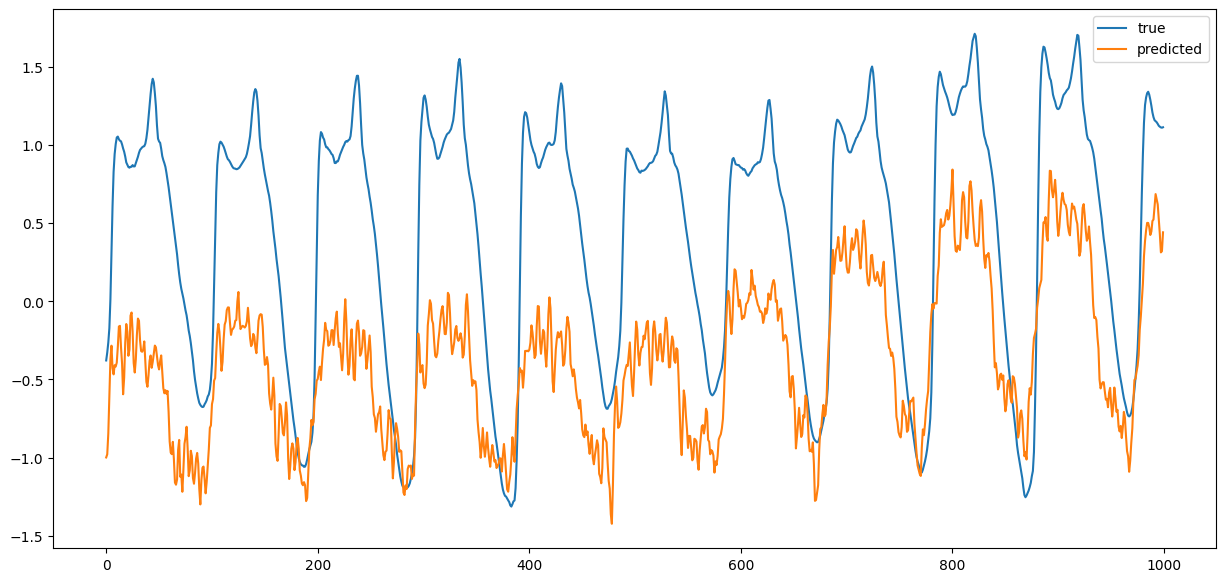

In [17]:
df_LR_test = df_test[[SIG_A, SIG_B, SIG_C, SIG_D, 'intervention', 'Phasenzuordnung']]
target_test = df_test[[TARGET]]

# convert to numpy array
X_test = df_LR_test.to_numpy()
y_test = target_test.to_numpy()

# print(reg.predict(np.array(X_test)))
# print(y_test)

#calculate the mean squared error
from sklearn.metrics import mean_squared_error
print('MSE: ', mean_squared_error(y_test, reg.predict(X_test)))

# calculate l1 loss
from sklearn.metrics import mean_absolute_error
print('L1: ', mean_absolute_error(y_test, reg.predict(X_test)))


# plot the first 1000 results 
# increase the size of the plot
plt.rcParams['figure.figsize'] = [15, 7]
plt.plot(y_test[:1000], label='true')
plt.plot(reg.predict(X_test[:1000]), label='predicted')
plt.legend()